<a href="https://colab.research.google.com/github/leonardijulia/LandslideChangeDetection/blob/main/Demo_Multispectral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing necessary libraries

In [1]:
!pip install rasterio kornia imagecodecs torchgeo



---


# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/PAPER/Metric-CD'
%pwd

/content/drive/MyDrive/PAPER/Metric-CD


'/content/drive/MyDrive/PAPER/Metric-CD'



---


# Imports

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import pandas as pd
from datetime import datetime

#Importing the necessary models
from models.resnet import ResNet
from models.dino import SSL4EO_DINO_Encoder
from torchgeo.models import ViTSmall16_Weights

import torch
import torch.nn as nn
import torch.optim as optim
import sklearn
import random
import kornia
from torchvision import transforms as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, cohen_kappa_score

from utils.common_utils import optimize
from utils.cd_utils import image_loss, feature_loss, contrastive_loss, inference_on_patch
from utils.data_transforms import ColorJitter, ColorJitterMulti
from utils.multi_landslide_dataset import MultiLandslideDataset
from utils.mahalanobis import MahalanobisDis
from utils.loss import info_loss, feature_InfoNce_loss, cm_InfoNce_loss
#from utils.losses_multi import image_loss_multi, feature_loss_multi, context_loss_multi, sparsity_penalty_multi
#from utils.encoder_features import VGG_Net, Encoder_Net

torch.backends.cudnn.enabled   = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor



---


# Load the multispectral data

## Define the data paths and the transforms

In [5]:
PATH_TRAIN = '/content/drive/MyDrive/PAPER/Metric-CD/cd_datasets/Landslides_multi/training'
PATH_TEST = '/content/drive/MyDrive/PAPER/Metric-CD/cd_datasets/Landslides_multi/test'

In [6]:
transforms_tif = kornia.augmentation.container.AugmentationSequential(
    kornia.geometry.transform.Resize(size=(224,224)),
    #other spatial augmentations?
)

transforms_cm = F.Compose([
    F.ToTensor(),
    F.Resize((224,224)),
])

## Load the data with 13 bands

**TO DO:** Check how to apply PCC on all 13 images//augmentation

---

In [7]:
# For 13 bands
train_dataset = MultiLandslideDataset(path=PATH_TRAIN, transforms=transforms_tif, is_train=True)
test_dataset  = MultiLandslideDataset(path=PATH_TEST, transforms=transforms_tif, transforms_cm=transforms_cm, is_train=False)

# Split the dataset into training and validation sets
dataset_size               = len(train_dataset)
val_size                   = int(0.2 * dataset_size)  # 20% for validation
train_size                 = dataset_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Wrap the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle=False)
val_dataloader   = DataLoader(val_dataset, batch_size = 1, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size = 1, shuffle=False)

# Test if the data load correctly
train_features = next(iter(train_dataloader))
val_features   = next(iter(val_dataloader))
test_features  = next(iter(test_dataloader))

## Load the data with 3 (RGB) bands

In [ ]:
# For 3 bands
trainRGB_dataset = MultiLandslideDataset(path=PATH_TRAIN, transforms=transforms_tif, RGB=True, ImgNetNorm=False, PCC=True, is_train=True)
testRGB_dataset  = MultiLandslideDataset(path=PATH_TEST, transforms=transforms_tif, transforms_cm=transforms_cm, RGB=True, ImgNetNorm=False, PCC=True, is_train=False)

# Split the dataset into training and validation sets
datasetRGB_size                  = len(trainRGB_dataset)
valRGB_size                      = int(0.2 * datasetRGB_size)  # 20% for validation
trainRGB_size                    = datasetRGB_size - valRGB_size
trainRGB_dataset, valRGB_dataset = random_split(trainRGB_dataset, [trainRGB_size, valRGB_size])

# Wrap the DataLoader
trainRGB_dataloader = DataLoader(trainRGB_dataset, batch_size = 1, shuffle=False)
valRGB_dataloader   = DataLoader(valRGB_dataset, batch_size = 1, shuffle=False)
testRGB_dataloader  = DataLoader(testRGB_dataset, batch_size = 1, shuffle=False)

# Test if the data load correctly
trainRGB_features = next(iter(trainRGB_dataloader))
valRGB_features   = next(iter(valRGB_dataloader))
testRGB_features  = next(iter(testRGB_dataloader))

## Check for shape and values of loaded data

In [8]:
print(f"Feature batch shape: {train_features[0].size()}")

Feature batch shape: torch.Size([1, 13, 224, 224])


In [9]:
for b in range(13):
  print(f"Band: {b + 1}, min: {torch.round(train_features[0][0][b].min(), decimals=0)}, max: {torch.round(train_features[0][0][b].max(), decimals=0)}")

Band: 1, min: -1.0, max: 3.0
Band: 2, min: -1.0, max: 3.0
Band: 3, min: -1.0, max: 3.0
Band: 4, min: -1.0, max: 3.0
Band: 5, min: -1.0, max: 3.0
Band: 6, min: -2.0, max: 3.0
Band: 7, min: -2.0, max: 3.0
Band: 8, min: -2.0, max: 3.0
Band: 9, min: -2.0, max: 3.0
Band: 10, min: -2.0, max: 3.0
Band: 11, min: -1.0, max: 3.0
Band: 12, min: -1.0, max: 3.0
Band: 13, min: -1.0, max: 3.0


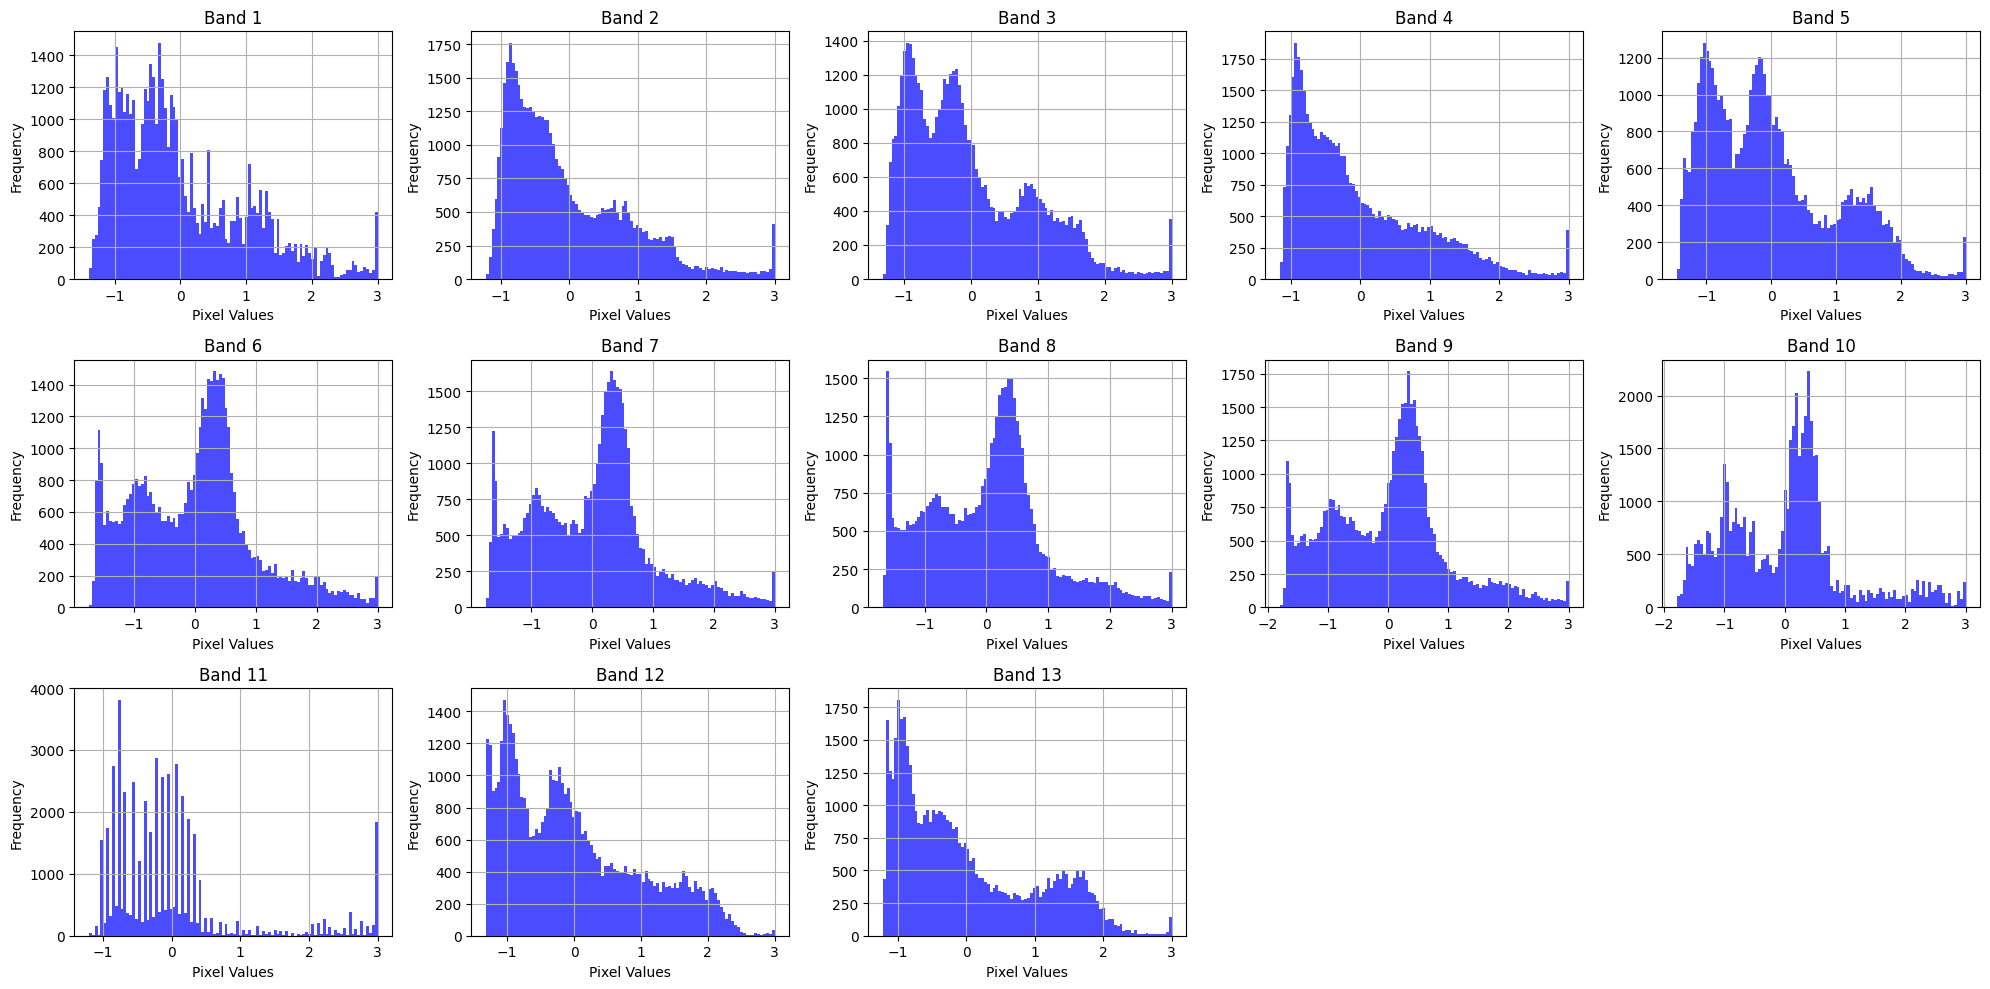

In [10]:
def plot_histograms(image: torch.Tensor, band_names=None, bins=100):
    """
    Plots histograms of the pixel values for each band in the image.

    Args:
        image (torch.Tensor): Standardized image tensor of shape (bands, H, W).
        band_names (list of str, optional): List of band names for labeling.
        bins (int, optional): Number of bins for the histogram.
    """
    bands, H, W = image.shape
    image = image.view(bands, -1).cpu().numpy()  # Flatten and convert to numpy

    plt.figure(figsize=(20, 10))
    for b in range(bands):
        plt.subplot(3, (bands + 2) // 3, b + 1)  # Adjust rows/cols for number of bands
        plt.hist(image[b], bins=bins, color='blue', alpha=0.7)
        plt.title(f'Band {b + 1}' if band_names is None else band_names[b])
        plt.xlabel('Pixel Values')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example Usage
# Assuming `pre_img` and `post_img` are the standardized images
# For demonstration, we'll only plot the pre-image
band_names = [f"Band {i}" for i in range(1, 14)]  # Sentinel-2 has 13 bands
plot_histograms(train_features[0][0], band_names=band_names)



---


# Set up



## Downloading the weights for DINO encoder (no need to rerun)

In [ ]:
weights = ViTSmall16_Weights.SENTINEL2_ALL_DINO
weights = weights.get_state_dict(progress=True)

Downloading: "https://hf.co/torchgeo/vit_small_patch16_224_sentinel2_all_dino/resolve/5b41dd418a79de47ac9f5be3e035405a83818a62/vit_small_patch16_224_sentinel2_all_dino-36bcc127.pth" to /root/.cache/torch/hub/checkpoints/vit_small_patch16_224_sentinel2_all_dino-36bcc127.pth
100%|██████████| 86.4M/86.4M [00:02<00:00, 43.7MB/s]


## Network set up

In [11]:
# General parameters
pad           = 'reflection'
OPT_OVER      = 'net & encoder'
OPTIMIZER     = 'adam'
input_depth   = 13 # bands
reg_noise_std = 0.03

# Parameters of Deep Change Dector
LR               = 0.0001
reg_noise_std    = 0.03
num_iter         = 50
threshold        = 0.7
N_feature_maps   = 3
requires_grad   = True

# Loss parameters
distance_measure_context = torch.nn.L1Loss()
distance_measure2        = torch.nn.L1Loss() #torch.nn.CosineSimilarity()
distance_measure         = torch.nn.L1Loss() #torch.nn.MSELoss()
InfoNCE_loss             = info_loss(temp_c = 1, temp_nc = 1) # investigate this

# Define change prediction network
net = ResNet(input_depth, 1, 32, 32, act_fun='LeakyReLU')
net = net.type(dtype)

# Define the encoder (DINO for S2 13 bands data)
weights      = 'vit_small_patch16_224_sentinel2_all_dino-36bcc127.pth'
weights_meta = ViTSmall16_Weights.SENTINEL2_ALL_DINO
in_chans     = weights_meta.meta['in_chans']

Encoder = SSL4EO_DINO_Encoder(encoder_weights = weights,
                              download_url    = "https://drive.google.com/drive/folders/1NQmnZz5gerRHTEYlI5s7r8Mq0QTakEZJ",
                              input_size      = 224,
                              input_bands     = {"Sentinel-2": ["band1", "band2", "band3", "band4", "band5", "band6", "band7", "band8", "band9", "band10", "band11", "band12", "band13"]},
                              output_layers   = [3, 5, 7, 11],
                              output_dim      = 384,
                              in_chans        = in_chans,
                              )

Encoder = Encoder.type(dtype)
Encoder.eval()  # in the original here it was set to .eval() but I changed that
for param in Encoder.parameters():
    param.requires_grad = False

# *NOT USED ANYMORE* The old VGG ImageNet RGB Encoder
# VGGEncoder = VGG_Net(resize=False, requires__grad=requires__grad, fine_tune=False).cuda()
# VGGEncoder.eval()
# for param in VGGEncoder.parameters():
    # param.requires_grad = requires__grad

# Printing number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print('Number of params: %d' % s)

Number of params: 607297




---


# Train loop

In [12]:
# Setting up the experiment folder
experiment_folder = input("Enter folder to store this run checkpoints: ")
experiment_folder = os.path.join('RESULTS/TIF_FULL_ViT/', experiment_folder)
if not os.path.exists(experiment_folder):
  os.makedirs(experiment_folder)

Enter folder to store this run checkpoints: 200125_std


In [18]:
parameters        = [x for x in net.parameters()] #list(net.parameters()) + list(Encoder.parameters()) #
optimizer         = optim.Adam(parameters, lr=LR)
#scheduler         = optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

def run_epoch(encoder, pcg, dataloader, optimizer=None, scheduler=None, is_training=True):
    """
    Runs a single epoch (training or validation).
    Args:
        encoder:     The feature extraction model (Encoder).
        pcg:         The change prediction model (PCG).
        dataloader:  DataLoader for training or validation.
        optimizer:   Optimizer for training (None during validation).
        scheduler:   Learning rate scheduler (None during validation).
        is_training: Whether the epoch is training or validation.
    Returns:
        avg_loss:    Average loss for the epoch.
    """
    i = 0
    running_loss = 0.0
    color_jitter = ColorJitterMulti([0.2, 0.2])

    if is_training:
      #encoder.train()
      pcg.train()
    else:
      #encoder.eval()
      pcg.eval()

    with torch.set_grad_enabled(is_training):
        for img_A, img_B in dataloader:
          # Convert images to tensors on cuda()
          img_A, img_B = img_A.type(dtype), img_B.type(dtype)

          # Forward pass
          net_input = torch.abs(img_A - img_B)
          out = pcg(net_input)
          pred_cm = out[0, 0, :, :]
          pred_ncm = 1.0 - pred_cm

          # Extract features
          imgA_feat, imgB_feat = encoder(img_A), encoder(img_B)

          # Apply color jitter and extract features
          imgA_aug, imgB_aug = color_jitter(img_A.cpu()).type(dtype), color_jitter(img_B.cpu()).type(dtype)
          imgA_aug_feat, imgB_aug_feat = encoder(imgA_aug), encoder(imgB_aug)

          # Compute losses
          [loss_s_img, loss_d_img] = image_loss(img_A, img_B, pred_cm, pred_ncm, distance_measure, distance_measure)
          [loss_s_feat, loss_d_feat] = feature_loss(imgA_feat, imgB_feat, pred_cm, pred_ncm, distance_measure2, distance_measure, N_feature_maps)
          [loss_s_feat_aug, loss_d_feat_aug] = feature_loss(imgA_aug_feat, imgB_aug_feat, pred_cm, pred_ncm, distance_measure2, distance_measure, N_feature_maps)
          loss_aug = contrastive_loss(imgA_feat, imgA_aug_feat, distance_measure2, 3) + contrastive_loss(imgB_feat, imgB_aug_feat, distance_measure2, 3)
          loss_cm = cm_InfoNce_loss(pred_cm, pred_ncm, InfoNCE_loss)

          total_loss = (
                  (loss_s_img + loss_d_img) +
                  (loss_s_feat + loss_d_feat) +
                  (loss_s_feat_aug + loss_d_feat_aug) +
                  loss_aug + loss_cm
              )
          if is_training:
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

          i += 1
          running_loss += total_loss.item()
          if i%20==19:
            last_loss = total_loss / 20 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            #running_loss = 0

    avg_loss = running_loss / len(dataloader)
    if scheduler and is_training:
      scheduler.step()
    return avg_loss

# Training loop
timestamp         = datetime.now().strftime('%Y%m%d_%H%M%S')
best_val_loss     = 1e6
rising_counter    = 0

# Initialize loss tracking lists
training_losses   = []
validation_losses = []

for epoch in range(num_iter):
    i            = 0
    running_loss = 0
    last_loss    = 0
    print(f"\nEpoch {epoch + 1}/{num_iter}")

    # Training phase
    train_loss = run_epoch(Encoder, net, train_dataloader, optimizer, is_training=True)
    print(f"Train Loss: {train_loss:.4f}")
    training_losses.append(train_loss)

    # Validation phase
    val_loss = run_epoch(Encoder, net, val_dataloader, is_training=False)
    print(f"Validation Loss: {val_loss:.4f}")
    validation_losses.append(val_loss)

    # Check early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        rising_counter = 0
        model_path = os.path.join(experiment_folder, f"model_{timestamp}_epoch_{epoch + 1}.pth")
        print(f"Validation loss improved. Saving model to {model_path}")
        torch.save(net.state_dict(), model_path)
    else:
        rising_counter += 1

    # Log learning rate
    #print(f"Learning Rate: {scheduler.get_last_lr()[0]}")

    if rising_counter >= 5:
        print("Early stopping triggered due to no improvement in validation loss.")
        break



Epoch 1/50
  batch 20 loss: 0.2982306480407715
  batch 40 loss: 0.189941868185997
  batch 60 loss: 0.19396920502185822
  batch 80 loss: 0.16600346565246582
  batch 100 loss: 0.10587117820978165
  batch 120 loss: 0.08013813942670822
Train Loss: 3.2705
  batch 20 loss: 0.06385602056980133
Validation Loss: 3.6347
Validation loss improved. Saving model to RESULTS/TIF_FULL_ViT/200125_std/model_20250120_080919_epoch_1.pth

Epoch 2/50
  batch 20 loss: 0.2987363338470459
  batch 40 loss: 0.1887042075395584
  batch 60 loss: 0.18753857910633087
  batch 80 loss: 0.16271352767944336
  batch 100 loss: 0.09427068382501602
  batch 120 loss: 0.07153017073869705
Train Loss: 3.1624
  batch 20 loss: 0.06262795627117157
Validation Loss: 3.5962
Validation loss improved. Saving model to RESULTS/TIF_FULL_ViT/200125_std/model_20250120_080919_epoch_2.pth

Epoch 3/50
  batch 20 loss: 0.29686352610588074
  batch 40 loss: 0.18503247201442719
  batch 60 loss: 0.18838000297546387
  batch 80 loss: 0.161018356680870

KeyboardInterrupt: 

In [21]:
val_losses_cpu = []
for loss in validation_losses:
  #loss = loss.cpu()
  val_losses_cpu.append(loss)

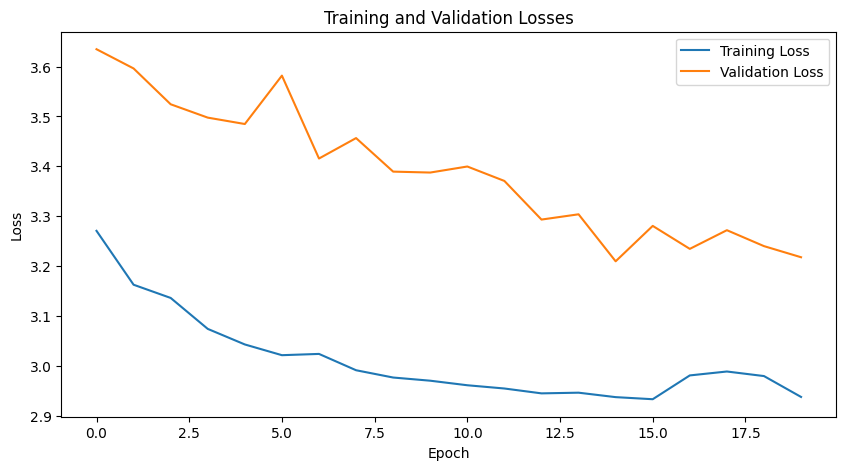

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses_cpu, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

## old loop

In [ ]:
# Training loop
#----- Color Jittering parameters -----#
color_adjust_para = [0.2, 0.2]#, 0.2, 0.2]

#Img1 and Img2 color jittering
Img1_Jitter = ColorJitterMulti(color_adjust_para)
Img2_Jitter = ColorJitterMulti(color_adjust_para)

p          = list(net.parameters()) + list(Encoder.parameters()) #p = [x for x in net.parameters()]
optimizer  = optim.Adam(p, lr=LR)
scheduler  = optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
best_vloss = 1e6
timestamp  = datetime.now().strftime('%Y%m%d_%H%M%S')

training_losses   = []
validation_losses = []
rising            = 0

for epoch in range(num_iter):
  i            = 0
  running_loss = 0
  last_loss    = 0
  net.train(True)
  print('EPOCH {}:'.format(epoch))

  for img_A, img_B in train_dataloader:

    # Converting numpy arrays to pytorch tensors
    imgA_var = img_A.type(dtype)
    imgB_var = img_B.type(dtype)

    net_in = torch.abs(imgA_var-imgB_var) # In the paper this is Mahalanobis distance
    out    = net(net_in) # FF step

    # Change probability (Pc) and unchanged probability (Pc') map
    pred_cm  = out[0, 0, :, :] # out from the D-CPG
    pred_ncm = 1.0 - pred_cm

    # Image features
    imgA_feat = Encoder(img_A.type(dtype)) # FF step of the Encoder on raw imgs
    imgB_feat = Encoder(img_B.type(dtype))

    # -------- pixel to pixel loss function -------#
    # Applying color jittering
    imgA_aug = Img1_Jitter(img_A.cpu()).type(dtype) #[0]
    imgB_aug = Img2_Jitter(img_B.cpu()).type(dtype) #[0]

    # Feature level similarity and dissimilarity from VGG pretrained
    imgA_aug_feat = Encoder(imgA_aug) # FF step of the Encoder of augmented images for
    imgB_aug_feat = Encoder(imgB_aug) # context consistency loss

    #--------- Loss FUNCTIONS-------
    [loss_s_img, loss_d_img]           = image_loss(imgA_var, imgB_var, pred_cm, pred_ncm, distance_measure, distance_measure) # in the paper img1&2 are after PCC - in this case this is not true
    [loss_s_feat, loss_d_feat]         = feature_loss(imgA_feat, imgB_feat, pred_cm, pred_ncm, distance_measure2, distance_measure, N_feature_maps)
    [loss_s_feat_aug, loss_d_feat_aug] = feature_loss(imgA_aug_feat, imgB_aug_feat, pred_cm, pred_ncm, distance_measure2, distance_measure, N_feature_maps) # ??? WHAT IS THIS???? here I changes from 2 imgA to imgA and imgB ##feature_loss_multi(imgA_feat, imgB_feat, distance_measure2, distance_measure) # gain, here and in the img_loss, paper = Mahalanobis, here L1
    loss_aug                           = contrastive_loss(imgA_feat, imgA_aug_feat, distance_measure2, 3) + contrastive_loss(imgB_feat, imgB_aug_feat, distance_measure2, 3)
    loss_cm                            = cm_InfoNce_loss(pred_cm, pred_ncm, InfoNCE_loss)

    total_loss  = (loss_s_img + loss_d_img) + (loss_s_feat + loss_d_feat) + (loss_s_feat_aug + loss_d_feat_aug) + loss_aug + loss_cm


    # OTHER EXPERIMENTS
    #context_loss                       = context_loss_multi(imgA_feat, imgB_feat, imgA_aug_feat, imgB_aug_feat, distance_measure_context)
    #sparsity_penatly                   = sparsity_penalty_multi(pred_cm)
    #total_loss                         = (loss_s_img + loss_d_img) + (loss_s_feat + loss_d_feat) + context_loss + loss_cm + sparsity_penatly
    #[loss_s_feat_aug, loss_d_feat_aug] = feature_loss(imgA_aug_feat, imgB_aug_feat, pred_cm, pred_ncm, distance_measure2, distance_measure) # here I changes from 2 imgA to imgA and imgB
    #loss_aug                           = contrastive_loss(imgA_feat, imgA_aug_feat, distance_measure2, 3) + contrastive_loss(imgB_feat, imgB_aug_feat, distance_measure2, 3)
    #loss_cm                            = cm_InfoNce_loss(pred_cm, pred_ncm, InfoNCE_loss)


    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    i += 1

    running_loss += total_loss.item()
    if i%20==19:
      last_loss = running_loss / 20 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      running_loss = 0

  scheduler.step()
  print(f"Learning Rate after epoch {epoch+1}: {scheduler.get_last_lr()[0]}")

  # Validation loop
  running_vloss = 0.0
  net.eval()
  with torch.no_grad():
    for A_val, B_val in val_dataloader:

      # Converting numpy arrays to pytorch tensors
      imgA_var = A_val.type(dtype)
      imgB_var = B_val.type(dtype)

      net_in = torch.abs(imgA_var-imgB_var) # In the paper this is Mahalanobis distance
      out = net(net_in) # FF step

      # Change probability (Pc) and unchanged probability (Pc') map
      pred_cm = out[0, 0, :, :] # out from the D-CPG
      pred_ncm = 1.0 - pred_cm

      # Image features
      imgA_feat = Encoder(A_val.type(dtype)) # FF step of the Encoder on raw imgs
      imgB_feat = Encoder(B_val.type(dtype))

      # -------- pixel to pixel loss function -------#
      # Applying color jittering
      imgA_aug = Img1_Jitter(A_val.cpu()).type(dtype) #[0]
      imgB_aug = Img2_Jitter(B_val.cpu()).type(dtype) #[0]

      # Feature level similarity and dissimilarity from VGG pretrained
      imgA_aug_feat = Encoder(imgA_aug) # FF step of the Encoder of augmented images for
      imgB_aug_feat = Encoder(imgB_aug) # context consistency loss

       #--------- Loss FUNCTIONS-------
      [loss_s_img_val, loss_d_img_val]           = image_loss(imgA_var, imgB_var, pred_cm, pred_ncm, distance_measure, distance_measure) # in the paper img1&2 are after PCC - in this case this is not true
      [loss_s_feat_val, loss_d_feat_val]         = feature_loss(imgA_feat, imgB_feat, pred_cm, pred_ncm, distance_measure2, distance_measure, N_feature_maps)
      [loss_s_feat_aug_val, loss_d_feat_aug_val] = feature_loss(imgA_aug_feat, imgB_aug_feat, pred_cm, pred_ncm, distance_measure2, distance_measure, N_feature_maps) # ??? WHAT IS THIS???? here I changes from 2 imgA to imgA and imgB ##feature_loss_multi(imgA_feat, imgB_feat, distance_measure2, distance_measure) # gain, here and in the img_loss, paper = Mahalanobis, here L1
      loss_aug_val                           = contrastive_loss(imgA_feat, imgA_aug_feat, distance_measure2, 3) + contrastive_loss(imgB_feat, imgB_aug_feat, distance_measure2, 3)
      loss_cm_val                            = cm_InfoNce_loss(pred_cm, pred_ncm, InfoNCE_loss)

      total_val_loss  = (loss_s_img_val + loss_d_img_val) + (loss_s_feat_val + loss_d_feat_val) + (loss_s_feat_aug_val + loss_d_feat_aug_val) + loss_aug_val + loss_cm_val


      # OTHER EXPERIMENTS
      #context_loss                       = context_loss_multi(imgA_feat, imgB_feat, imgA_aug_feat, imgB_aug_feat, distance_measure_context)
      #sparsity_penatly                   = sparsity_penalty_multi(pred_cm)
      #total_loss                         = (loss_s_img + loss_d_img) + (loss_s_feat + loss_d_feat) + context_loss + loss_cm + sparsity_penatly
      #[loss_s_feat_aug, loss_d_feat_aug] = feature_loss(imgA_aug_feat, imgB_aug_feat, pred_cm, pred_ncm, distance_measure2, distance_measure) # here I changes from 2 imgA to imgA and imgB
      #loss_aug                           = contrastive_loss(imgA_feat, imgA_aug_feat, distance_measure2, 3) + contrastive_loss(imgB_feat, imgB_aug_feat, distance_measure2, 3)
      #loss_cm                            = cm_InfoNce_loss(pred_cm, pred_ncm, InfoNCE_loss)


      running_vloss += total_val_loss

  avg_vloss = running_vloss / (len(val_dataset))
  print('LOSS train {} valid {}'.format(last_loss, avg_vloss))
  training_losses.append(last_loss)
  validation_losses.append(avg_vloss)

  if epoch >= 1 and avg_vloss > best_vloss:
    rising += 1
  else:
    rising = 0

  if rising >= 10:
    print("Early stopping")
    break

  # Track best performance, and save the model's state
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_name = 'model_{}_{}'.format(timestamp, epoch)
    model_path = os.path.join(experiment_folder, model_name)
    print(f"Saving model at {model_path}")
    torch.save(net.state_dict(), model_path)




---


# Test loop

In [23]:
net.load_state_dict(torch.load(model_path))

<ipython-input-23-2a026c207a5d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [24]:
# inference on patch in cd_utils
def inference_on_patch(patch_A, patch_B):
  net_in = torch.abs(patch_A-patch_B)
  with torch.no_grad():
    out = net(net_in)
  pred_cm = out[0,0,:,:]

  return pred_cm

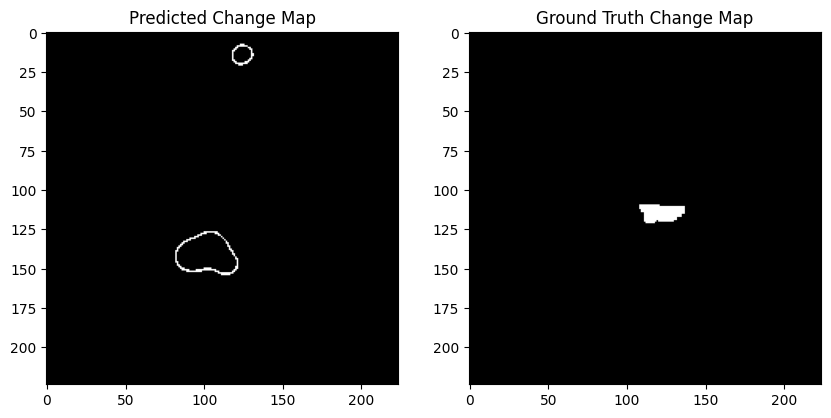

In [27]:
  A_test, B_test, CM = next(iter(test_dataloader))

  A_test = A_test.type(dtype)
  B_test = B_test.type(dtype)
  CM_ones = np.zeros_like(CM)
  CM_ones[CM > 0] = 1

  pred_cm = inference_on_patch(A_test, B_test)
  pred_cm_cpu = pred_cm.cpu()
  mask_pred = np.zeros_like(pred_cm_cpu)
  mask_pred[pred_cm_cpu >0.9999] = 1

  CM_np = np.expand_dims(CM_ones, 0)

  CM_np_binary = CM_np.astype(int).flatten()
  mask_pred_binary = mask_pred.astype(int).flatten()

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(mask_pred, cmap='Greys_r')
  plt.title("Predicted Change Map")
  plt.subplot(1, 2, 2)
  plt.imshow(CM_np.squeeze(), cmap='Greys_r')
  plt.title("Ground Truth Change Map")
  plt.show()

In [28]:
metrics_list = []
image_folder = experiment_folder
for A_test, B_test, CM in test_dataloader:

  A_test = A_test.type(dtype)
  B_test = B_test.type(dtype)
  CM_ones = np.zeros_like(CM)
  CM_ones[CM > 0] = 1

  pred_cm = inference_on_patch(A_test, B_test)
  pred_cm_cpu = pred_cm.cpu()
  mask_pred = np.zeros_like(pred_cm_cpu)
  mask_pred[pred_cm_cpu > 0.99] = 1

  CM_np = np.expand_dims(CM_ones, 0)

  CM_np_binary = CM_np.astype(int).flatten()
  mask_pred_binary = mask_pred.astype(int).flatten()

  img_name = f"test_{len(metrics_list)}.png"
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(mask_pred, cmap='Greys_r')
  plt.title("Predicted Change Map")
  plt.subplot(1, 2, 2)
  plt.imshow(CM_np.squeeze(), cmap='Greys_r')
  plt.title("Ground Truth Change Map")
  plt.savefig(os.path.join(image_folder, img_name))
  plt.close()

  OA = accuracy_score(CM_np_binary, mask_pred_binary)
  UA = precision_score(CM_np_binary, mask_pred_binary)
  Recall = recall_score(CM_np_binary, mask_pred_binary)
  FMeasure = f1_score(CM_np_binary, mask_pred_binary)
  fpr, tpr, thres = roc_curve(CM_np_binary, pred_cm_cpu.numpy().astype(int).flatten())
  AUC = auc(fpr, tpr)
  Kappa = cohen_kappa_score(CM_np_binary, mask_pred_binary)

  metrics_dict = {
        'OA': OA,
        'UA': UA,
        'Recall': Recall,
        'FMeasure': FMeasure,
        'AUC': AUC,
        'Kappa': Kappa
    }
  metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)
metrics_path = os.path.join(image_folder, 'test_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)


In [29]:
print(f"average OA for the test set: {round(np.mean(metrics_df['OA'])*100,2)}%")
print(f"average UA for the test set: {round(np.mean(metrics_df['UA'])*100,2)}%")
print(f"average Recall for the test set: {round(np.mean(metrics_df['Recall'])*100,2)}%")
print(f"average F1 for the test set: {round(np.mean(metrics_df['FMeasure'])*100,2)}%")
print(f"average AUC for the test set: {round(np.mean(metrics_df['AUC'])*100,2)}%")
print(f"average Kappa for the test set: {round(np.mean(metrics_df['Kappa'])*100,2)}%")

average OA for the test set: 18.63%
average UA for the test set: 3.28%
average Recall for the test set: 97.3%
average F1 for the test set: 6.14%
average AUC for the test set: 49.98%
average Kappa for the test set: 1.08%


In [ ]:
prev = pd.read_csv('/content/drive/MyDrive/PAPER/Metric-CD/RESULTS/TIF_RGB_VGG/TIF_RGB_best_run/test_metrics.csv')

In [ ]:
print(f"average OA for the test set: {round(np.mean(prev['OA'])*100,2)}%")
print(f"average UA for the test set: {round(np.mean(prev['UA'])*100,2)}%")
print(f"average Recall for the test set: {round(np.mean(prev['Recall'])*100,2)}%")
print(f"average F1 for the test set: {round(np.mean(prev['FMeasure'])*100,2)}%")
print(f"average AUC for the test set: {round(np.mean(prev['AUC'])*100,2)}%")
print(f"average Kappa for the test set: {round(np.mean(prev['Kappa'])*100,2)}%")

average OA for the test set: 96.61%
average UA for the test set: 37.06%
average Recall for the test set: 41.01%
average F1 for the test set: 32.33%
average AUC for the test set: 69.62%
average Kappa for the test set: 31.16%




---


# Experiments

### to understand the encoder

In [30]:
imgA = test_features[0].type(dtype)
imgB = test_features[1].type(dtype)
CM = test_features[2].type(dtype)

imgA_feat = Encoder(imgA)
imgB_feat = Encoder(imgB)

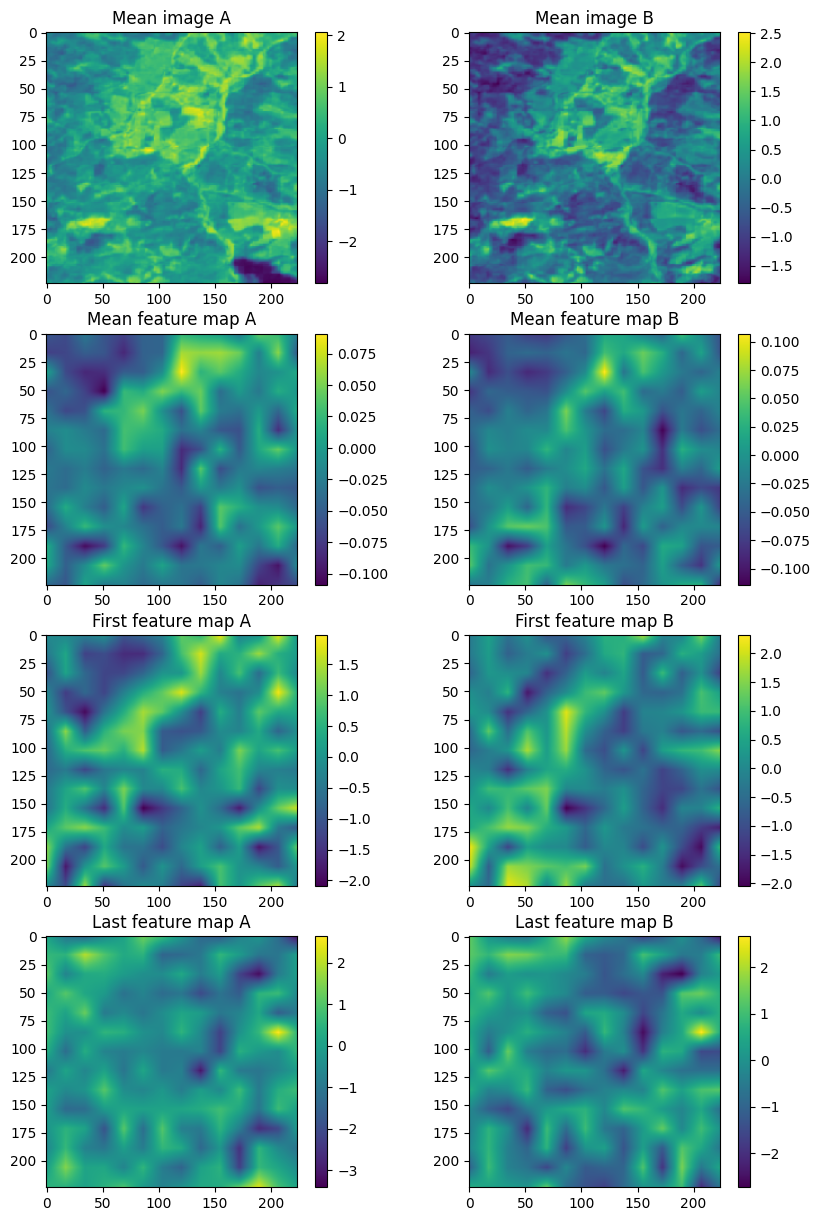

In [31]:
import torch.nn.functional as F

imgA_feat_cpu = imgA_feat[2].detach().cpu()
imgB_feat_cpu = imgB_feat[2].detach().cpu()

upsampled_map_A = F.interpolate(imgA_feat_cpu, size=(224, 224), mode='bilinear', align_corners=True)
mean_upsampled_map_A = torch.mean(upsampled_map_A, dim=1, keepdim=True)
first_feature_map_A = upsampled_map_A[0][0]
last_feature_map_A = upsampled_map_A[0][-1]

upsampled_map_B = F.interpolate(imgB_feat_cpu, size=(224, 224), mode='bilinear', align_corners=True)
mean_upsampled_map_B = torch.mean(upsampled_map_B, dim=1, keepdim=True)
first_feature_map_B = upsampled_map_B[0][0]
last_feature_map_B = upsampled_map_B[0][-1]

plt.figure(figsize=(10, 15))
plt.subplot(4, 2, 1)
plt.title("Mean image A")
plt.imshow(torch.mean(imgA, dim=1, keepdim=True)[0][0].detach().cpu().numpy(), cmap='viridis')
plt.colorbar()

plt.subplot(4, 2, 2)
plt.title("Mean image B")
plt.imshow(torch.mean(imgB, dim=1, keepdim=True)[0][0].detach().cpu().numpy(), cmap='viridis')
plt.colorbar()

plt.subplot(4, 2, 3)
plt.title("Mean feature map A")
plt.imshow(mean_upsampled_map_A[0,0], cmap='viridis')
plt.colorbar()

plt.subplot(4, 2, 4)
plt.title("Mean feature map B")
plt.imshow(mean_upsampled_map_B[0,0], cmap='viridis')
plt.colorbar()

plt.subplot(4, 2, 5)
plt.title("First feature map A")
plt.imshow(first_feature_map_A, cmap='viridis')
plt.colorbar()

plt.subplot(4, 2, 6)
plt.title("First feature map B")
plt.imshow(first_feature_map_B, cmap='viridis')
plt.colorbar()

plt.subplot(4, 2, 7)
plt.title("Last feature map A")
plt.imshow(last_feature_map_A, cmap='viridis')
plt.colorbar()

plt.subplot(4, 2, 8)
plt.title("Last feature map B")
plt.imshow(last_feature_map_B, cmap='viridis')
plt.colorbar()

plt.show()

### to understand the D-PCG

In [32]:
# Defining the input and performing the FF step on an image pair
net_in = torch.abs(imgA-imgB) # In the paper this is Mahalanobis distance --> change or think what could be best
out = net(net_in)

# Change probability (Pc) and unchanged probability (Pc') map
pred_cm = out[0,0,:,:] # out from the D-CPG
pred_ncm = 1.0 - pred_cm

pred_cm = pred_cm.detach().cpu().numpy()
pred_ncm = pred_ncm.detach().cpu().numpy()

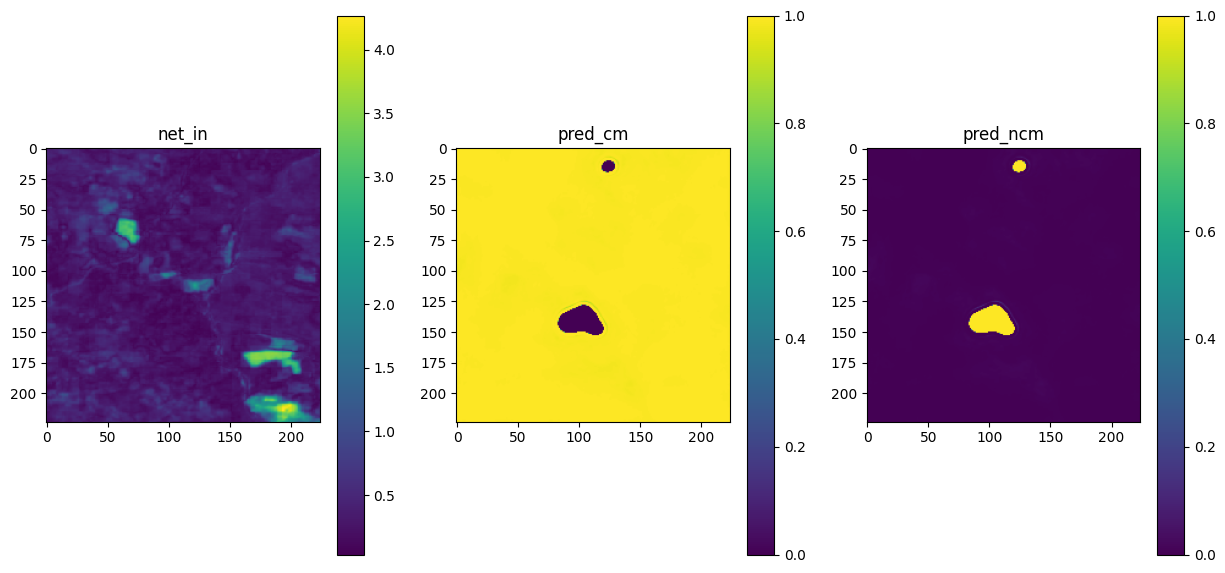

In [33]:
# Plotting the network input the pred_cm and and pred_ncm

plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 1)
plt.title("net_in")
plt.imshow(torch.mean(net_in.squeeze(), dim=0, keepdim=False).detach().cpu().numpy(), cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("pred_cm")
plt.imshow(pred_cm, cmap='viridis')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("pred_ncm")
plt.imshow(pred_ncm, cmap='viridis')
plt.colorbar()
plt.show()

In [34]:
# Subsetting the model to check what is going on
net_s = net.model[:37]
out = net_s(net_in)

In [35]:
# The sigmoid after the batch norm
sigm = net.model[37]
last_step = sigm(out)

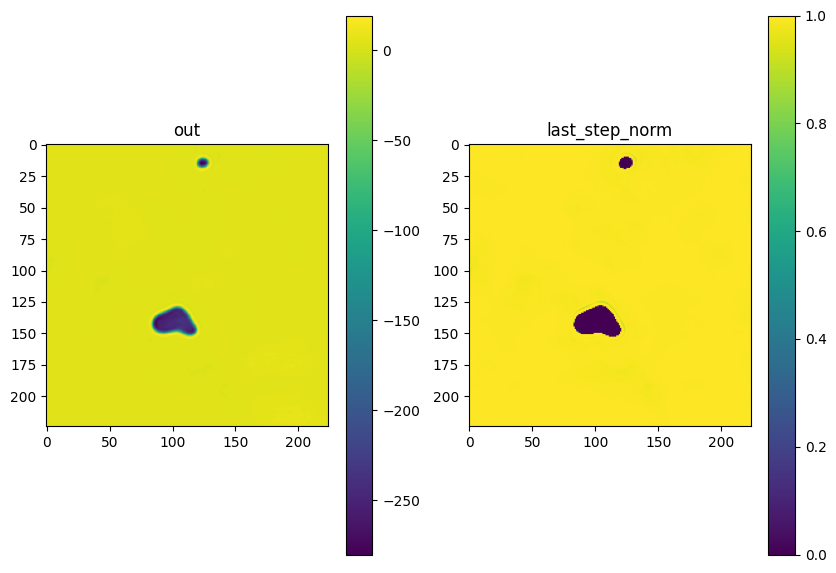

In [36]:
# Plotting the individual outputs after the whole net without the sigmoid,
# after the batch norm and after the sigmoid with or without the batch norm

plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("out")
plt.imshow(out.squeeze().detach().cpu().numpy(), cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("last_step_norm")
plt.imshow(last_step.squeeze().detach().cpu().numpy(), cmap='viridis') # The sigmoid adds this weird bottom and right edges
plt.colorbar()
plt.show()

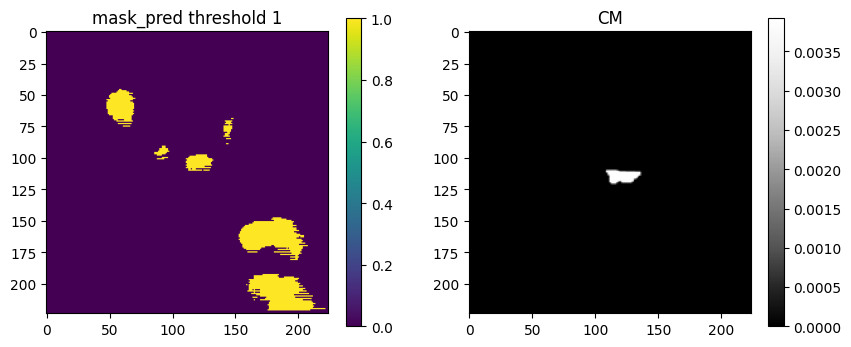

In [ ]:
mask_pred = np.zeros_like(pred_cm)
mask_pred[last_step.squeeze().detach().cpu().numpy() > 0.9999] = 1
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("mask_pred threshold 1")
plt.imshow(mask_pred, cmap='viridis')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("CM")
plt.imshow(CM.squeeze().detach().cpu().numpy(), cmap='Grays_r') # The sigmoid adds this weird bottom and right edges
plt.colorbar()

### to understand the feature loss

In [ ]:
imgA = upsampled_map_A[0]
imgA_mean = torch.mean(imgA, (1,2), True)
print("mean: ", imgA_mean.shape)
imgA_std = torch.std(imgA, (1,2), True).unsqueeze(1).unsqueeze(2)
print("std: ", imgA_std.shape)
imgA_norm = (imgA - imgA_mean)/(imgA_std + 1e-9)
print("norm: ", imgA_norm.shape)

mean:  torch.Size([768, 1, 1])
std:  torch.Size([768, 1, 1])
norm:  torch.Size([768, 224, 224])


In [ ]:
imgB = upsampled_map_B[0]
imgB_mean = torch.mean(imgB, (1,2), True)
print("mean: ", imgB_mean.shape)
imgB_std = torch.std(imgB, (1,2), True).unsqueeze(1).unsqueeze(2)
print("std: ", imgB_std.shape)
imgB_norm = (imgB - imgB_mean)/(imgB_std + 1e-9)
print("norm: ", imgB_norm.shape)

mean:  torch.Size([768, 1, 1])
std:  torch.Size([768, 1, 1])
norm:  torch.Size([768, 224, 224])


In [ ]:
reverse_last_step = 1.0 - last_step
change_s  = last_step*(last_step.detach()>reverse_last_step.detach())
no_change_s  = last_step*(last_step.detach()<reverse_last_step.detach())

change_s = change_s.cpu()
no_change_s = no_change_s.cpu()

In [ ]:
termA_s = no_change_s * imgA_norm
termB_s = no_change_s * imgB_norm
termA_d = change_s * imgA_norm
termB_d = change_s * imgB_norm

print("termA_s: ", termA_s.shape)
print("termB_s: ", termB_s.shape)
print("termA_d: ", termA_d.shape)
print("termB_d: ", termB_d.shape)

termA_s:  torch.Size([1, 768, 224, 224])
termB_s:  torch.Size([1, 768, 224, 224])
termA_d:  torch.Size([1, 768, 224, 224])
termB_d:  torch.Size([1, 768, 224, 224])


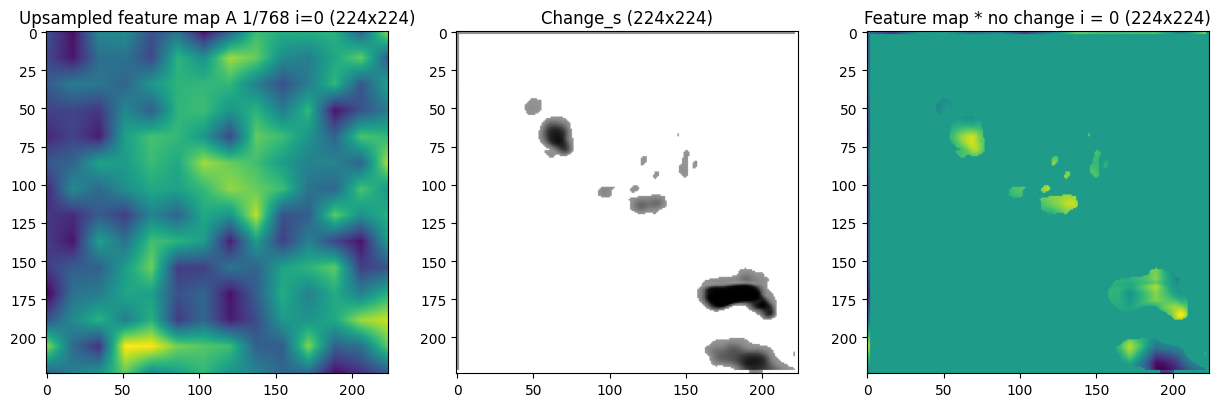

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("Upsampled feature map A 1/768 i=0 (224x224)")
plt.imshow(upsampled_map_A[0,0], cmap='viridis')

plt.subplot(1, 3, 2)
plt.title("Change_s (224x224)")
plt.imshow(change_s[0, 0].detach().cpu().numpy(), cmap='Grays')

plt.subplot(1, 3, 3)
plt.title("Feature map * no change i = 0 (224x224)")
plt.imshow(termA_d[0, 0].detach().cpu().numpy(), cmap='viridis')

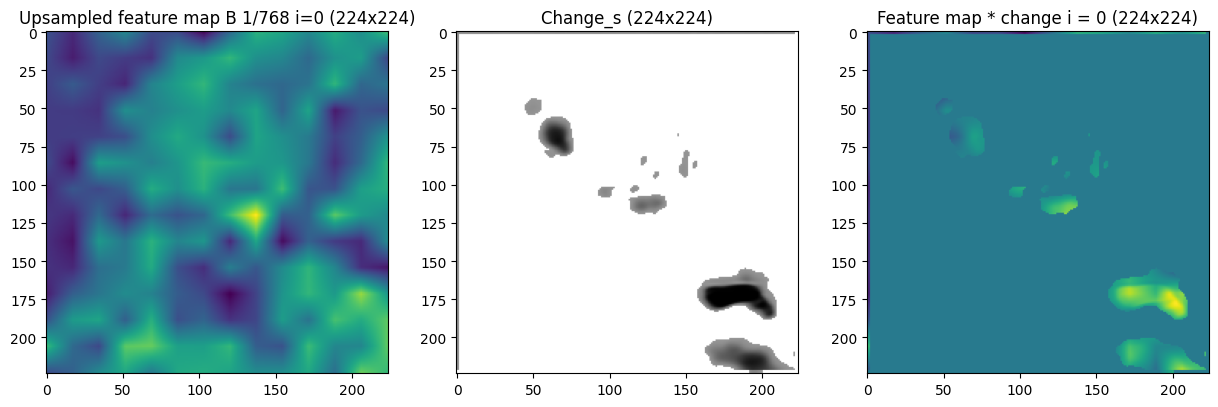

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("Upsampled feature map B 1/768 i=0 (224x224)")
plt.imshow(upsampled_map_B[0,0], cmap='viridis')

plt.subplot(1, 3, 2)
plt.title("Change_s (224x224)")
plt.imshow(change_s[0, 0].detach().cpu().numpy(), cmap='Grays')

plt.subplot(1, 3, 3)
plt.title("Feature map * change i = 0 (224x224)")
plt.imshow(termB_d[0,0].detach().cpu().numpy(), cmap='viridis')

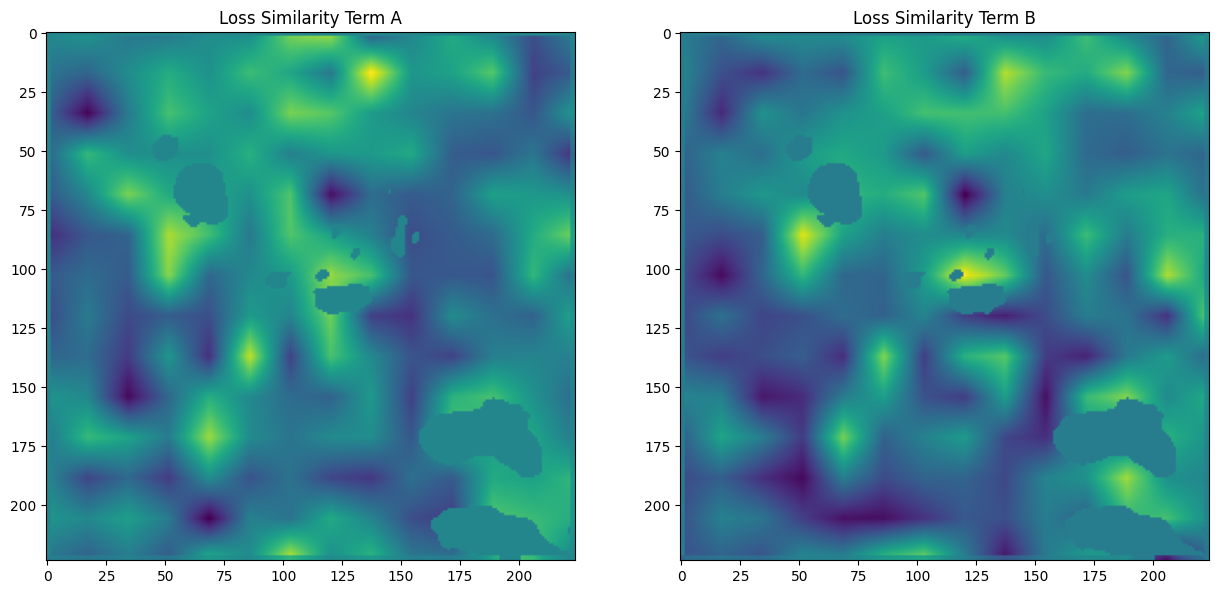

In [ ]:
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title("Loss Similarity Term A")
plt.imshow(termA_s[0, 1].detach().cpu().numpy(), cmap='viridis')

plt.subplot(1, 2, 2)
plt.title("Loss Similarity Term B")
plt.imshow(termB_s[0, 1].detach().cpu().numpy(), cmap='viridis')

In [ ]:
loss_s = distance_measure(termA_s, termB_s)
loss_d = distance_measure(termA_d, termB_d)
print("loss_s: ", loss_s)
print("loss_d: ", loss_d)

loss_s:  tensor(0.2073, grad_fn=<MeanBackward0>)
loss_d:  tensor(0.0519, grad_fn=<MeanBackward0>)


#### checking with the VGG

In [ ]:
 imgA_feat2 = Encoder2(trainRGB_features[0].type(dtype))

In [ ]:
for i in range(len(imgA_feat2)):
  print(imgA_feat2[i].shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
